In [1]:
import torch

If available GPU exists then use it (CUDA), otherwise use CPU

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
print(device.type)

device

cpu


device(type='cpu')

In [4]:
from torchvision import datasets, transforms

In [5]:
train_dataset = datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])
)

test_dataset = datasets.MNIST(
    root="./data",
    train=False,
    download=True,
    transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])
)

In [6]:
from torch.utils.data import DataLoader, random_split

In [7]:
# the batch size for the data loader
batch_size = 48

# Split the training dataset into training and validation sets
train_size = 55000
val_size = 5000
train_dataset, val_dataset = random_split(train_dataset,[train_size,val_size])

# Create data loaders for the three sets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Sequential 1:

##  Model with no hidden layer

In [8]:
import torch.nn as nn

In [9]:
# Define the neural network model
class Sequential_1(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(28*28, 10)
        
    # Define the forward propagation of the model, that is, 
    # how to return the required model output based on the input X
    def forward(self, x):
        x = x.reshape(-1, 28*28) #this is flatten
        x = self.fc (x) #this is dense
        return nn.functional.softmax(x, dim=1)

In [10]:
import torch.optim as optim

In [11]:
# learning_rate for optimizer
learning_rate = 0.01 

In [12]:
# Create an instance of the model
model = Sequential_1().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

model

Sequential_1(
  (fc): Linear(in_features=784, out_features=10, bias=True)
)

In [14]:
from torchsummary import summary

In [15]:
summary(model, (1, 784), device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 10]           7,850
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.03
Estimated Total Size (MB): 0.03
----------------------------------------------------------------


In [16]:
import os

In [17]:
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'

#check 'https://graphviz.org/download/' first, then add the bin path to the environment

In [18]:
from torchviz import make_dot

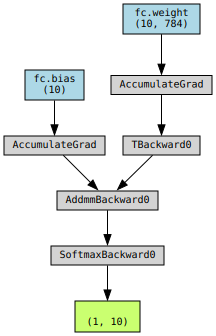

In [19]:
x = torch.rand(1, 28*28).to(device)
y_hat = model(x)

make_dot(y_hat, params=dict(model.named_parameters()))
#make_dot(y_hat, params=dict(model.named_parameters()), show_attrs=True, show_saved=True)

In [20]:
# pip install graphviz 
# pip install torchview

In [21]:
import torchvision
from torchview import draw_graph


(dot.exe:1212): Pango-WARNING **: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


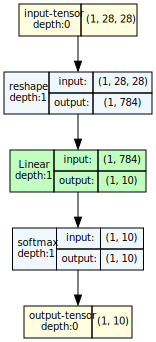

In [22]:
model_graph = draw_graph(model, input_size=(1,28,28), expand_nested=True)

model_graph.visual_graph

In [23]:
train_loss_list = []
val_loss_list = []
val_accuracy_list = []

num_epochs = 10

# Train the model
best_val_loss = float('inf')
for epoch in range(num_epochs):
    train_loss = 0
    model.train()
    for i, (data, target) in enumerate(train_loader):   # for data, target in train_loader:
        optimizer.zero_grad()
        data, target = data.to(device), target.to(device)  
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * len(data)

    # Calculate validation loss
    model.eval()
    correct = 0
    val_loss = 0
    for data, target in val_loader:
        data, target = data.to(device), target.to(device)
        with torch.no_grad():
            output = model(data)
            loss = criterion(output, target)
        val_loss += loss.item() * len(data)
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()   #How many elements are correct? (predicted == labels).sum().item()

    # Print training and validation loss , avg
    with torch.no_grad():
        train_loss /= len(train_loader.dataset)
        val_loss /= len(val_loader.dataset)
        val_accuracy = correct / len(val_loader.dataset)
        print(f'Epoch {epoch+1}: Train Loss: {train_loss:.6f}, Valid Loss: {val_loss:.6f}, Valid Accuracy={val_accuracy:.6f}')

        train_loss_list.append(train_loss)
        val_loss_list.append(val_loss)
        val_accuracy_list.append(val_accuracy)    

        # Check if this is the best model so far based on validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict().copy()
        
print('\nTraining is completed.')

Epoch 1: Train Loss: 1.665189, Valid Loss: 1.593383, Valid Accuracy=0.891400
Epoch 2: Train Loss: 1.581613, Valid Loss: 1.576595, Valid Accuracy=0.904600
Epoch 3: Train Loss: 1.570005, Valid Loss: 1.567957, Valid Accuracy=0.907000
Epoch 4: Train Loss: 1.563885, Valid Loss: 1.565962, Valid Accuracy=0.909400
Epoch 5: Train Loss: 1.559439, Valid Loss: 1.561511, Valid Accuracy=0.911200
Epoch 6: Train Loss: 1.556422, Valid Loss: 1.560310, Valid Accuracy=0.914000
Epoch 7: Train Loss: 1.554186, Valid Loss: 1.557373, Valid Accuracy=0.914400
Epoch 8: Train Loss: 1.552088, Valid Loss: 1.557217, Valid Accuracy=0.914000
Epoch 9: Train Loss: 1.550431, Valid Loss: 1.554116, Valid Accuracy=0.916600
Epoch 10: Train Loss: 1.549028, Valid Loss: 1.555374, Valid Accuracy=0.912600

Training is completed.


In [24]:
import matplotlib.pyplot as plt
%matplotlib inline 

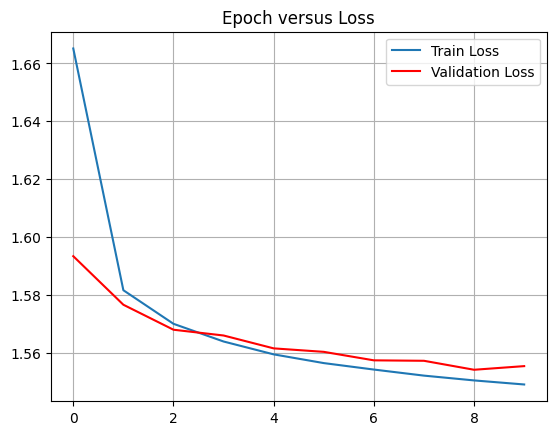

In [25]:
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, c='r', label='Validation Loss')
plt.title('Epoch versus Loss')
plt.legend(loc="upper right")
plt.grid()
plt.show()

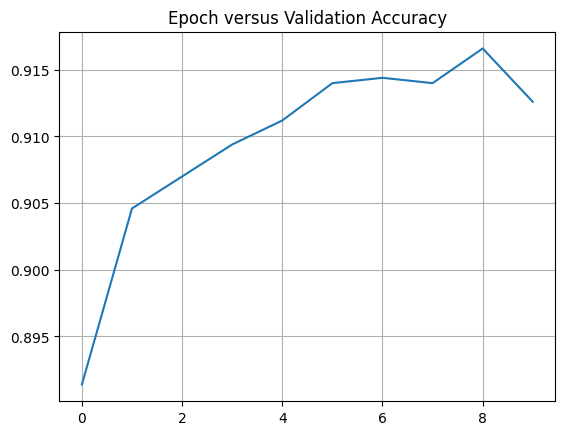

In [26]:
plt.plot(val_accuracy_list)
plt.title('Epoch versus Validation Accuracy')
plt.grid()
plt.show()

In [27]:
# Load the best model state
model.load_state_dict(best_model_state)

<All keys matched successfully>

In [28]:
# Test the model on the test set
test_loss = 0
correct = 0

model.eval()
for data, target in test_loader:    
    data, target = data.to(device), target.to(device)
    with torch.no_grad():        
        outputs = model(data)
        loss = criterion(outputs, target)
    test_loss += loss.item() * len(data)
    pred = outputs.argmax(dim=1, keepdim=True)
    correct += pred.eq(target.view_as(pred)).sum().item()  #(predicted == labels).sum().item()

test_loss /= len(test_loader.dataset)
test_acc = correct / len(test_loader.dataset)
print(f'Test Loss: {test_loss:.6f}, Test Accuracy: {test_acc:.6f}')

Test Loss: 1.548146, Test Accuracy: 0.920000


# Sequential 2: 


## Model with single hidden layer

In [29]:
# Define the neural network model with one hidden layer
class Sequential_2(nn.Module):
    def __init__(self):
        super().__init__()        
        self.fc2 = nn.Linear(16, 10)
        self.fc1 = nn.Linear(28*28, 16)

    def forward(self, x):
        x = x.reshape(-1, 28*28)
        x = self.fc1(x)
        x = torch.sigmoid(x) #sigmoid in the hidden layer
        out = self.fc2(x) #no sigmoid on the output layer
        return torch.softmax(out, dim=1)

In [30]:
# learning_rate for optimizer
learning_rate = 0.001

In [31]:
# Create an instance of the model
model = Sequential_2().to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [32]:
summary(model, (1, 28*28), device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 16]          12,560
            Linear-2                   [-1, 10]             170
Total params: 12,730
Trainable params: 12,730
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.05
Estimated Total Size (MB): 0.05
----------------------------------------------------------------


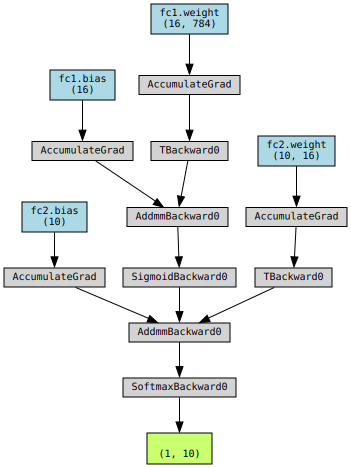

In [33]:
x = torch.rand(1, 28*28).to(device)
y_hat = model(x)

make_dot(y_hat, params=dict(model.named_parameters()))
#make_dot(y_hat, params=dict(model.named_parameters()), show_attrs=True, show_saved=True)


(dot.exe:8376): Pango-WARNING **: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


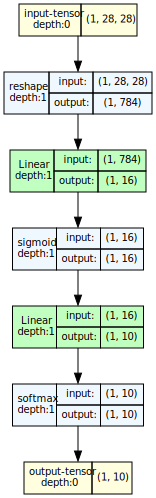

In [34]:
model_graph = draw_graph(model, input_size=(1,28,28), expand_nested=True)
model_graph.visual_graph

In [35]:
# Train the model and select the best model based on validation loss
train_loss_list = []
val_loss_list = []
val_accuracy_list = []

num_epochs = 20

best_val_loss = float('inf')
for epoch in range(num_epochs):
    model.train()
    train_loss = float('inf')
    for data, target in train_loader:
        optimizer.zero_grad()
        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * len(data)
    
    # Evaluate the model on the validation set
    model.eval()
    correct = 0
    val_loss = 0
    for data, target in val_loader:
        data, target = data.to(device), target.to(device)
        with torch.no_grad():
            output = model(data)
            val_loss += criterion(output, target).item() * len(data)
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
            
    with torch.no_grad():
        train_loss /= len(train_loader.dataset)
        val_loss /= len(val_loader.dataset)
        val_accuracy = correct / len(val_loader.dataset)        
        print(f'Epoch {epoch+1}: Train Loss={train_loss:.6f}, Valid Loss={val_loss:.6f}, Valid Accuracy={val_accuracy:.6f}')

        train_loss_list.append(train_loss)
        val_loss_list.append(val_loss)
        val_accuracy_list.append(val_accuracy)    

        # Save the model if it has the best validation loss so far
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model.state_dict().copy()
    
print('\nTraining is completed.')    

Epoch 1: Train Loss=inf, Valid Loss=1.710035, Valid Accuracy=0.826800
Epoch 2: Train Loss=inf, Valid Loss=1.654386, Valid Accuracy=0.835200
Epoch 3: Train Loss=inf, Valid Loss=1.587789, Valid Accuracy=0.903000
Epoch 4: Train Loss=inf, Valid Loss=1.574400, Valid Accuracy=0.912400
Epoch 5: Train Loss=inf, Valid Loss=1.567073, Valid Accuracy=0.911600
Epoch 6: Train Loss=inf, Valid Loss=1.558887, Valid Accuracy=0.917000
Epoch 7: Train Loss=inf, Valid Loss=1.555129, Valid Accuracy=0.918600
Epoch 8: Train Loss=inf, Valid Loss=1.556666, Valid Accuracy=0.917800
Epoch 9: Train Loss=inf, Valid Loss=1.548217, Valid Accuracy=0.923600
Epoch 10: Train Loss=inf, Valid Loss=1.545630, Valid Accuracy=0.925600
Epoch 11: Train Loss=inf, Valid Loss=1.545749, Valid Accuracy=0.925600
Epoch 12: Train Loss=inf, Valid Loss=1.547785, Valid Accuracy=0.920800
Epoch 13: Train Loss=inf, Valid Loss=1.541543, Valid Accuracy=0.928000
Epoch 14: Train Loss=inf, Valid Loss=1.538880, Valid Accuracy=0.930400
Epoch 15: Train

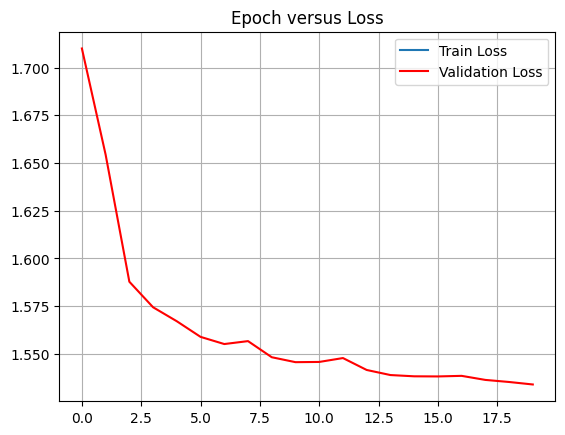

In [36]:
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, c='r', label='Validation Loss')
plt.title('Epoch versus Loss')
plt.legend(loc="upper right")
plt.grid()
plt.show()

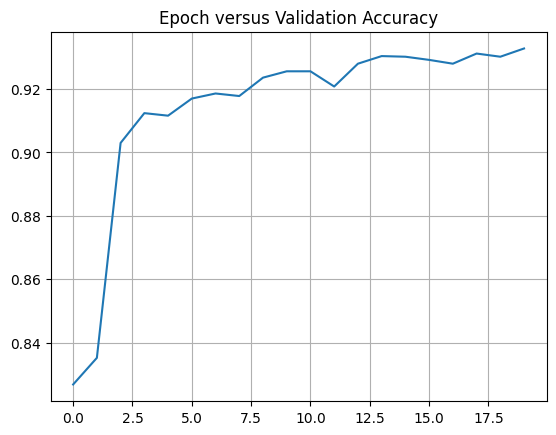

In [37]:
plt.plot(val_accuracy_list)
plt.title('Epoch versus Validation Accuracy')
plt.grid()
plt.show()

In [38]:
# Load the best model and evaluate it on the test set
model.load_state_dict(best_model)

<All keys matched successfully>

In [39]:
# Test the model on the test set
test_loss = 0
correct = 0

model.eval()
for data, target in test_loader:    
    data, target = data.to(device), target.to(device)
    with torch.no_grad():        
        outputs = model(data)
        loss = criterion(outputs, target)
    test_loss += loss.item() * len(data)
    pred = outputs.argmax(dim=1, keepdim=True)
    correct += pred.eq(target.view_as(pred)).sum().item()  #(predicted == labels).sum().item()

test_loss /= len(test_loader.dataset)
test_acc = correct / len(test_loader.dataset)
print(f'Test Loss: {test_loss:.6f}, Test Accuracy: {test_acc:.6f}')

Test Loss: 1.528277, Test Accuracy: 0.939300


# Sequential 3: 

## Deep model

In [40]:
 # Define the neural network model
class Sequential_3(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 128)          
        self.fc3 = nn.Linear(128, 96)
        self.fc4 = nn.Linear(96, 64)
        self.fc5 = nn.Linear(64, 32)
        self.fc6 = nn.Linear(32, 16)
        self.fc7 = nn.Linear(16, 10)      

    def forward(self, x):
        x = x.reshape(-1, 28*28)
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        x = torch.relu(x)
        x = self.fc3(x)
        x = torch.relu(x)
        x = self.fc4(x)
        x = torch.relu(x)
        x = self.fc5(x)
        x = torch.relu(x)
        x = torch.relu(self.fc6(x))
        out = self.fc7(x)
        return torch.softmax(out, dim=1)

In [41]:
# learning_rate for optimizer
learning_rate = 0.01 

In [42]:
# Create an instance of the model
model = Sequential_3().to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)  # Adam and RMSprop did not perform well.

In [43]:
summary(model, (1, 784), device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 256]         200,960
            Linear-2                  [-1, 128]          32,896
            Linear-3                   [-1, 96]          12,384
            Linear-4                   [-1, 64]           6,208
            Linear-5                   [-1, 32]           2,080
            Linear-6                   [-1, 16]             528
            Linear-7                   [-1, 10]             170
Total params: 255,226
Trainable params: 255,226
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.97
Estimated Total Size (MB): 0.98
----------------------------------------------------------------


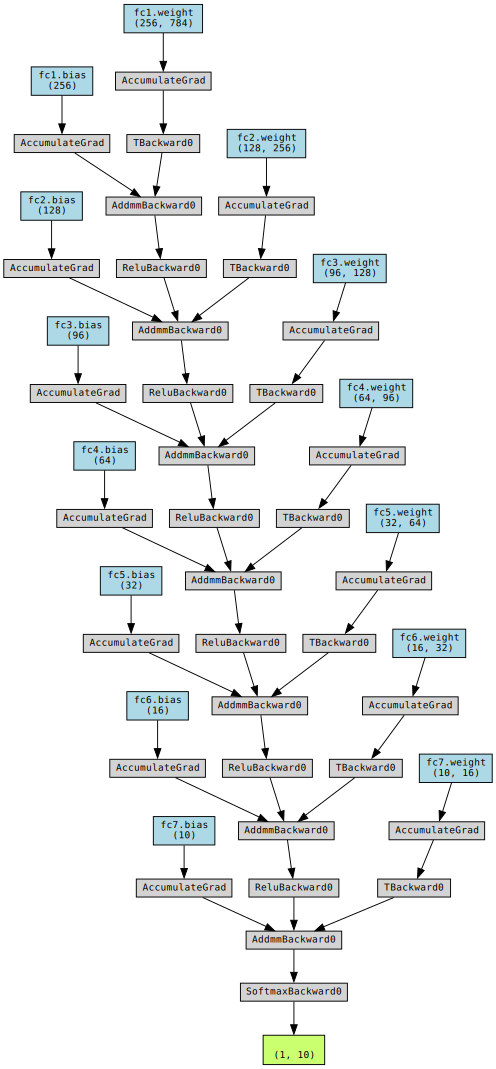

In [44]:
x = torch.rand(1, 28*28).to(device)
y_hat = model(x)

make_dot(y_hat, params=dict(model.named_parameters()))
#make_dot(y_hat, params=dict(model.named_parameters()), show_attrs=True, show_saved=True)


(dot.exe:11296): Pango-WARNING **: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


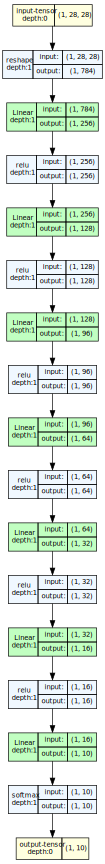

In [45]:
model_graph = draw_graph(model, input_size=(1,28,28), expand_nested=True)
model_graph.visual_graph

In [46]:
# Train the model and select the best model based on validation loss
train_loss_list = []
val_loss_list = []
val_accuracy_list = []

num_epochs = 20

best_val_loss = float('inf')
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for data, target in train_loader:
        optimizer.zero_grad()
        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * len(data)
    
    # Evaluate the model on the validation set
    model.eval()
    correct = 0
    val_loss = 0
    for data, target in val_loader:
        data, target = data.to(device), target.to(device)
        with torch.no_grad():
            output = model(data)
            val_loss += criterion(output, target).item() * len(data)
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
    
    with torch.no_grad():
        train_loss /= len(train_loader.dataset)
        val_loss /= len(val_loader.dataset)
        val_accuracy = correct / len(val_loader.dataset)        
        print(f'Epoch {epoch+1}: Train Loss={train_loss:.6f}, Valid Loss={val_loss:.6f}, Valid Accuracy={val_accuracy:.6f}')
    
        train_loss_list.append(train_loss)
        val_loss_list.append(val_loss)
        val_accuracy_list.append(val_accuracy)    

        # Save the model if it has the best validation loss so far
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model.state_dict().copy()
    
print('\nTraining is completed.')    

Epoch 1: Train Loss=2.301983, Valid Loss=2.301327, Valid Accuracy=0.114800
Epoch 2: Train Loss=2.277719, Valid Loss=2.186384, Valid Accuracy=0.207400
Epoch 3: Train Loss=2.059275, Valid Loss=1.813082, Valid Accuracy=0.673000
Epoch 4: Train Loss=1.758133, Valid Loss=1.723493, Valid Accuracy=0.738000
Epoch 5: Train Loss=1.724435, Valid Loss=1.713237, Valid Accuracy=0.746400
Epoch 6: Train Loss=1.709397, Valid Loss=1.696284, Valid Accuracy=0.754600
Epoch 7: Train Loss=1.603781, Valid Loss=1.554509, Valid Accuracy=0.908800
Epoch 8: Train Loss=1.546641, Valid Loss=1.546195, Valid Accuracy=0.914600
Epoch 9: Train Loss=1.538701, Valid Loss=1.550313, Valid Accuracy=0.910400
Epoch 10: Train Loss=1.533366, Valid Loss=1.576638, Valid Accuracy=0.884000
Epoch 11: Train Loss=1.531191, Valid Loss=1.529445, Valid Accuracy=0.932400
Epoch 12: Train Loss=1.530470, Valid Loss=1.536772, Valid Accuracy=0.923600
Epoch 13: Train Loss=1.527772, Valid Loss=1.530409, Valid Accuracy=0.929800
Epoch 14: Train Loss=

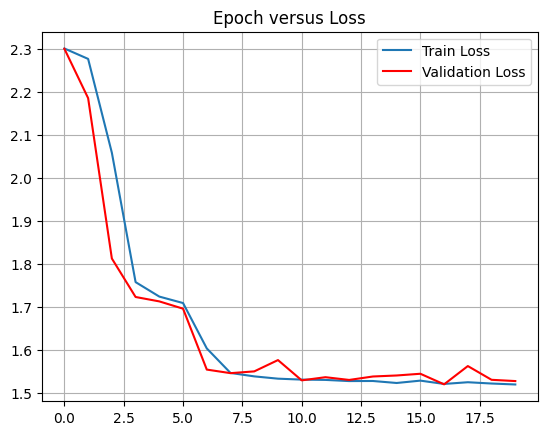

In [47]:
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, c='r', label='Validation Loss')
plt.title('Epoch versus Loss')
plt.legend(loc="upper right")
plt.grid()
plt.show()

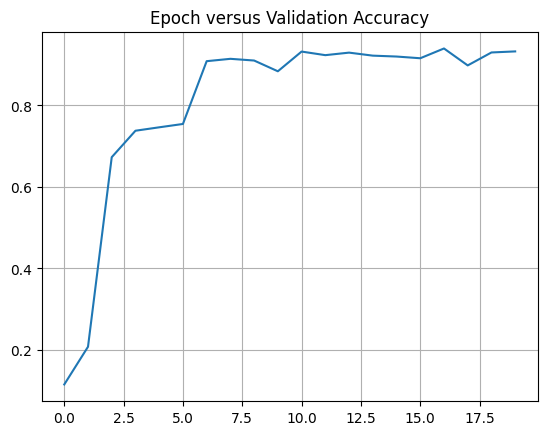

In [48]:
plt.plot(val_accuracy_list)
plt.title('Epoch versus Validation Accuracy')
plt.grid()
plt.show()

In [49]:
# Load the best model and evaluate it on the test set
model.load_state_dict(best_model)

<All keys matched successfully>

In [50]:
# Test the model on the test set
test_loss = 0
correct = 0

model.eval()
for data, target in test_loader:    
    data, target = data.to(device), target.to(device)
    with torch.no_grad():        
        outputs = model(data)
        loss = criterion(outputs, target)
    test_loss += loss.item() * len(data)
    pred = outputs.argmax(dim=1, keepdim=True)
    correct += pred.eq(target.view_as(pred)).sum().item()  #(predicted == labels).sum().item()

test_loss /= len(test_loader.dataset)
test_acc = correct / len(test_loader.dataset)
print(f'Test Loss: {test_loss:.6f}, Test Accuracy: {test_acc:.6f}')

Test Loss: 1.523422, Test Accuracy: 0.937500


# Deep model using class extended from nn.Module

In [51]:
 # Define the neural network model
class Complex_deep_model(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.hidden_left_1 = nn.Linear(28*28, 256)
        self.hidden_left_2 = nn.Linear(256, 128)
        self.hidden_left_3 = nn.Linear(128, 64)
        self.hidden_left_4 = nn.Linear(64, 32)

        self.hidden_right_1 = nn.Linear(28*28, 256)
        self.hidden_right_2 = nn.Linear(256, 128)
        self.hidden_right_3 = nn.Linear(128, 32)
        
        self.hidden_center_1 = nn.Linear(32+32, 24) 
        self.hidden_center_2 = nn.Linear(24, 16)
        self.output = nn.Linear(16, 10)

    
    def forward(self, x):
        x = self.flatten(x)
        
        x_left = torch.relu(self.hidden_left_1(x))
        x_left = torch.relu(self.hidden_left_2(x_left))
        x_left = torch.relu(self.hidden_left_3(x_left))
        x_left = torch.relu(self.hidden_left_4(x_left))
        
        x_right = torch.sigmoid(self.hidden_right_1(x))
        x_right = torch.sigmoid(self.hidden_right_2(x_right))
        x_right = torch.sigmoid(self.hidden_right_3(x_right))

        x = torch.cat((x_left, x_right), dim=1) #concatenate parallel layers

        x = torch.relu(self.hidden_center_1(x))
        x = torch.relu(self.hidden_center_2(x))
        x = self.output(x)
        
        return torch.softmax(x, dim=1)

In [52]:
# learning_rate for optimizer
learning_rate = 0.001 # very bad accuracy with 0.001 for 25 epochs

In [53]:
# Create an instance of the model
model = Complex_deep_model().to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

In [54]:
summary(model, (1, 784), device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 256]         200,960
            Linear-3                  [-1, 128]          32,896
            Linear-4                   [-1, 64]           8,256
            Linear-5                   [-1, 32]           2,080
            Linear-6                  [-1, 256]         200,960
            Linear-7                  [-1, 128]          32,896
            Linear-8                   [-1, 32]           4,128
            Linear-9                   [-1, 24]           1,560
           Linear-10                   [-1, 16]             400
           Linear-11                   [-1, 10]             170
Total params: 484,306
Trainable params: 484,306
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

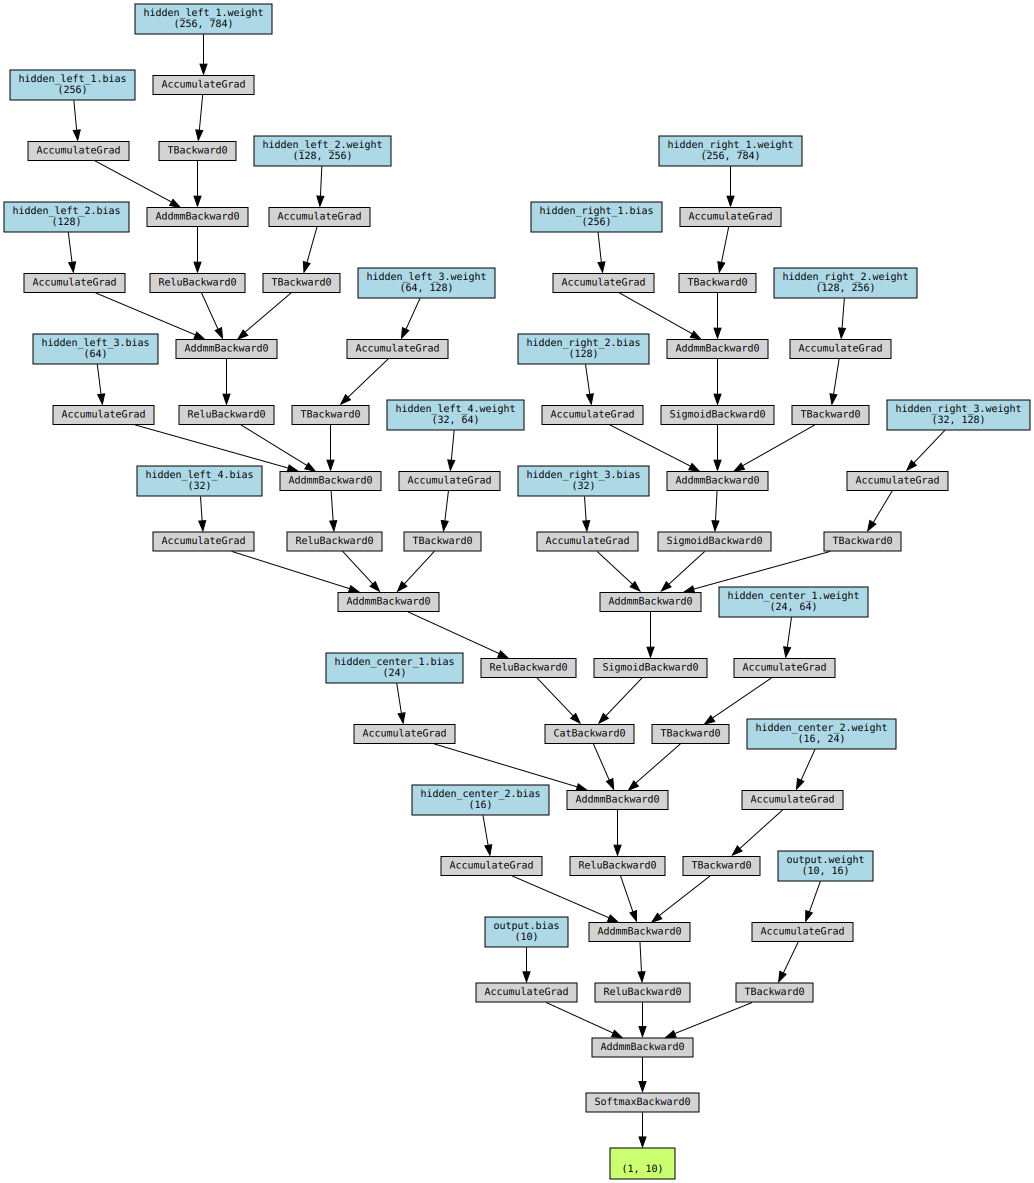

In [55]:
x = torch.rand(1, 28*28).to(device)
y_hat = model(x)

make_dot(y_hat, params=dict(model.named_parameters()))
#make_dot(y_hat, params=dict(model.named_parameters()), show_attrs=True, show_saved=True)


(dot.exe:7016): Pango-WARNING **: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


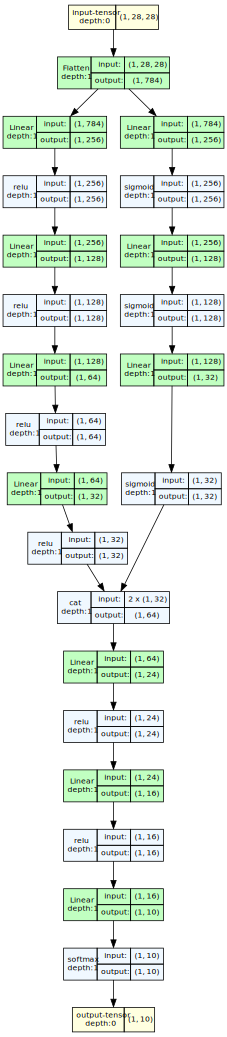

In [56]:
model_graph = draw_graph(model, input_size=(1,28,28), expand_nested=True)
model_graph.visual_graph

In [57]:
# Train the model and select the best model based on validation loss
train_loss_list = []
val_loss_list = []
val_accuracy_list = []

num_epochs = 10

best_val_loss = float('inf')
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for data, target in train_loader:
        optimizer.zero_grad()
        data, target = data.to(device),target.to(device)
        outputs = model(data)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * len(data)
    
    # Evaluate the model on the validation set
    model.eval()
    correct = 0
    val_loss = 0
    for data, target in val_loader:
        data, target = data.to(device), target.to(device)
        with torch.no_grad():
            output = model(data)
            val_loss += criterion(output, target).item() * len(data)
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
    
    with torch.no_grad():
        train_loss /= len(train_loader.dataset)
        val_loss /= len(val_loader.dataset)
        val_accuracy = correct / len(val_loader.dataset)        
        print(f'Epoch {epoch+1}: Train Loss={train_loss:.6f}, Valid Loss={val_loss:.6f}, Valid Accuracy={val_accuracy:.6f}')
    
        train_loss_list.append(train_loss)
        val_loss_list.append(val_loss)
        val_accuracy_list.append(val_accuracy)    

        # Save the model if it has the best validation loss so far
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model.state_dict().copy()
    
print('\nTraining is completed.')    

Epoch 1: Train Loss=1.830185, Valid Loss=1.667800, Valid Accuracy=0.800200
Epoch 2: Train Loss=1.586349, Valid Loss=1.564192, Valid Accuracy=0.898400
Epoch 3: Train Loss=1.554872, Valid Loss=1.551214, Valid Accuracy=0.910800
Epoch 4: Train Loss=1.543750, Valid Loss=1.538541, Valid Accuracy=0.923000
Epoch 5: Train Loss=1.538382, Valid Loss=1.553625, Valid Accuracy=0.907800
Epoch 6: Train Loss=1.537542, Valid Loss=1.528653, Valid Accuracy=0.933000
Epoch 7: Train Loss=1.533310, Valid Loss=1.536136, Valid Accuracy=0.925000
Epoch 8: Train Loss=1.528861, Valid Loss=1.528965, Valid Accuracy=0.932600
Epoch 9: Train Loss=1.533332, Valid Loss=1.547981, Valid Accuracy=0.912200
Epoch 10: Train Loss=1.530188, Valid Loss=1.556681, Valid Accuracy=0.904200

Training is completed.


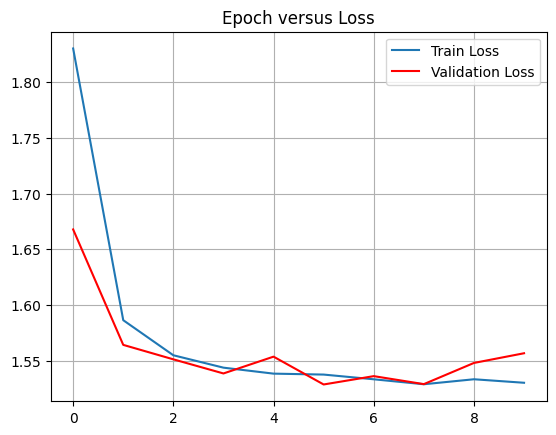

In [58]:
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, c='r', label='Validation Loss')
plt.title('Epoch versus Loss')
plt.legend(loc="upper right")
plt.grid()
plt.show()

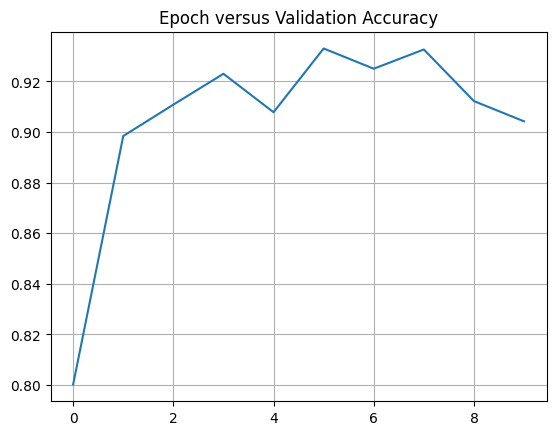

In [59]:
plt.plot(val_accuracy_list)
plt.title('Epoch versus Validation Accuracy')
plt.grid()
plt.show()

In [60]:
# Load the best model and evaluate it on the test set
model.load_state_dict(best_model)

<All keys matched successfully>

In [61]:
# Test the model on the test set
test_loss = 0
correct = 0

model.eval()
for data, target in test_loader:    
    data, target = data.to(device), target.to(device)
    with torch.no_grad():        
        outputs = model(data)
        loss = criterion(outputs, target)
    test_loss += loss.item() * len(data)
    pred = outputs.argmax(dim=1, keepdim=True)
    correct += pred.eq(target.view_as(pred)).sum().item()  #(predicted == labels).sum().item()

test_loss /= len(test_loader.dataset)
test_acc = correct / len(test_loader.dataset)
print(f'Test Loss: {test_loss:.6f}, Test Accuracy: {test_acc:.6f}')

Test Loss: 1.553978, Test Accuracy: 0.907500
